In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import scipy.stats as stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pprint import pprint

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import keras
from sklearn.metrics import f1_score,recall_score,precision_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['model.hdf5', 'model.png', 'sample_submission.csv', 'test', 'train', 'train.csv']


In [2]:
# Load the label names
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

labels_inverse = {}
for k,v in label_names.items():
    labels_inverse[v] = k

color_map = {
    "red": "microtubules", 
    "green": "endosomes", # this is what we're labelling
    "blue": "nucleus", 
    "yellow": "endoplasmatic reticulum"
}

Let's load the data  and take a peak at it.

In [3]:
train_labels = pd.read_csv("../input/train.csv", engine='python')
print(train_labels.head())

                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18


Okay - so we have a dataframe where the Id represents the filename of the image, and Target is a list of the labels.

Now, lets take a look at the picture files.

In [4]:
picture_files = os.listdir('../input/train')
pprint(picture_files[:10])

['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png',
 '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png',
 '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png',
 '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png',
 '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png',
 '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png',
 '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_green.png']


Alright, so there's a directory full of images with the IDs from above, followed by an underscore of \_red, \_yellow, \_blue, \_green.

What does the data look like?

In [5]:
def display_image_channel(id, channel='red'):
    filename = "../input/train/" + id + '_' + channel + '.png'
    im = cv2.imread(filename,0)
    
    plt.figure(figsize=(4,4))
    if channel == 'red':
        cmap_red = plt.cm.Reds_r
        cmap_red.set_bad(color='black')
        cmap_red.set_under(color='black')
        plt.title(color_map['red'], fontsize=15)
        plt.imshow(im,cmap=cmap_red, vmin=1)
    elif channel == 'green':
        cmap_green = plt.cm.Greens_r
        cmap_green.set_bad(color='black')
        cmap_green.set_under(color='black')
        plt.title(color_map['green'], fontsize=15)
        plt.imshow(im,cmap=cmap_green, vmin=1)
    elif channel == 'blue':
        cmap_blue = plt.cm.Blues_r
        cmap_blue.set_bad(color='black')
        cmap_blue.set_under(color='black')
        plt.title(color_map['blue'], fontsize=15)
        plt.imshow(im,cmap=cmap_blue, vmin=1)
    elif channel == 'yellow':
        cmap_yellow = plt.cm.Oranges_r
        cmap_yellow.set_bad(color='black')
        cmap_yellow.set_under(color='black')
        plt.title(color_map['yellow'], fontsize=15)
        plt.imshow(im, cmap=cmap_yellow, vmin=1)
    else:
        print("invalid channel")
        
    plt.show()

def display_all_channels_separately(id):
    filename_red =    "../input/train/" + id + '_red' +    '.png'
    filename_green =  "../input/train/" + id + '_green' +  '.png'
    filename_blue =   "../input/train/" + id + '_blue' +   '.png'
    filename_yellow = "../input/train/" + id + '_yellow' + '.png'
    
    im_red =    cv2.imread(filename_red,0)
    im_green =  cv2.imread(filename_green,0)
    im_blue =   cv2.imread(filename_blue,0)
    im_yellow = cv2.imread(filename_yellow,0)
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(2,2,1)
    cmap_red = plt.cm.Reds_r
    cmap_red.set_bad(color='black')
    cmap_red.set_under(color='black')
    plt.imshow(im_red, cmap=cmap_red, vmin=1)
    plt.title(color_map['red'], fontsize=15)
    
    plt.subplot(2,2,2)
    cmap_green = plt.cm.Greens_r
    cmap_green.set_bad(color='black')
    cmap_green.set_under(color='black')
    plt.imshow(im_green, cmap=cmap_green, vmin=1)
    plt.title(color_map['green'], fontsize=15)
    
    plt.subplot(2,2,3)
    cmap_blue = plt.cm.Blues_r
    cmap_blue.set_bad(color='black')
    cmap_blue.set_under(color='black')
    plt.imshow(im_blue, cmap=cmap_blue, vmin=1)
    plt.title(color_map['blue'], fontsize=15)

    
    plt.subplot(2,2,4)
    cmap_yellow = plt.cm.Oranges_r
    cmap_yellow.set_bad(color='black')
    cmap_yellow.set_under(color='black')
    plt.imshow(im_yellow, cmap=cmap_yellow, vmin=1)
    plt.title(color_map['yellow'], fontsize=15)
    
    plt.savefig("4channels.png")
    
    plt.show()

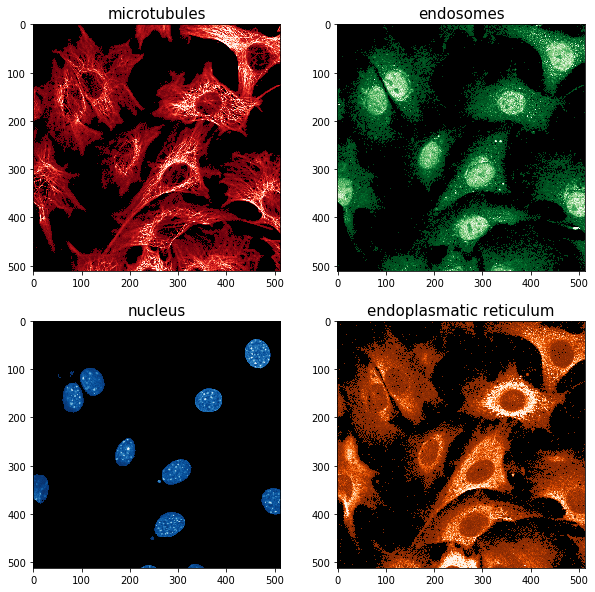

In [6]:
test_id = '27e40a9e-bba0-11e8-b2b9-ac1f6b6435d0'
display_all_channels_separately(test_id)

What does it look like if we combine them?

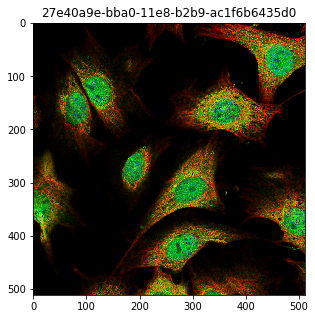

In [7]:
def display_image(id):
    filename_red =    "../input/train/" + id + '_red' +    '.png'
    filename_green =  "../input/train/" + id + '_green' +  '.png'
    filename_blue =   "../input/train/" + id + '_blue' +   '.png'
    filename_yellow = "../input/train/" + id + '_yellow' + '.png'
    
    size = (512, 512, 3)
    
    im_red =    np.array(cv2.imread(filename_red,0))
    im_green =  np.array(cv2.imread(filename_green,0))
    im_blue =   np.array(cv2.imread(filename_blue,0))
    im_yellow = np.array(cv2.imread(filename_yellow,0))

    mat = np.zeros(size, dtype=np.uint8)
    
    # yellow is red + green
    mat[:, :, 0] += (im_yellow/2).astype(np.uint8)  
    mat[:, :, 1] += (im_yellow/2).astype(np.uint8)
    
    # loop for R,G and B channels
    
    mat[:,:,0] += im_red
    mat[:,:,1] += im_green
    mat[:,:,2] += im_blue
    
    mat = (mat / mat.max() * 255).astype(np.uint8)
    plt.figure(figsize=(5,5))
    plt.title(id)
    plt.imshow(mat)
    plt.savefig("Example_Image.png")
    
display_image(test_id)

Now, we need to extract the labels for each training image.

In [8]:
num_samples = train_labels.shape[0]

print("There are", num_samples, "training images.")

train_label_names = train_labels.copy()
for k,v in label_names.items():
    train_label_names[v] = 0

def fill_labels(row):
    labels = np.array(row.Target.split()).astype(np.uint8)
    for label in labels:
        row[label_names[label]] = 1
    return row

train_label_names = train_label_names.apply(fill_labels, axis=1).drop(['Target'], axis=1)
print(train_labels.head())
train_label_names.head()

There are 31072 training images.
                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18


,Id,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


How many of each type are there? 

Frequency of top 5 labels:
Nucleoplasm        12885
Cytosol             8228
Plasma membrane     3777
Nucleoli            3621
Mitochondria        2965
dtype: int64

Frequency of bottom 5 labels:
Peroxisomes         53
Endosomes           45
Lysosomes           28
Microtubule ends    21
Rods & rings        11
dtype: int64


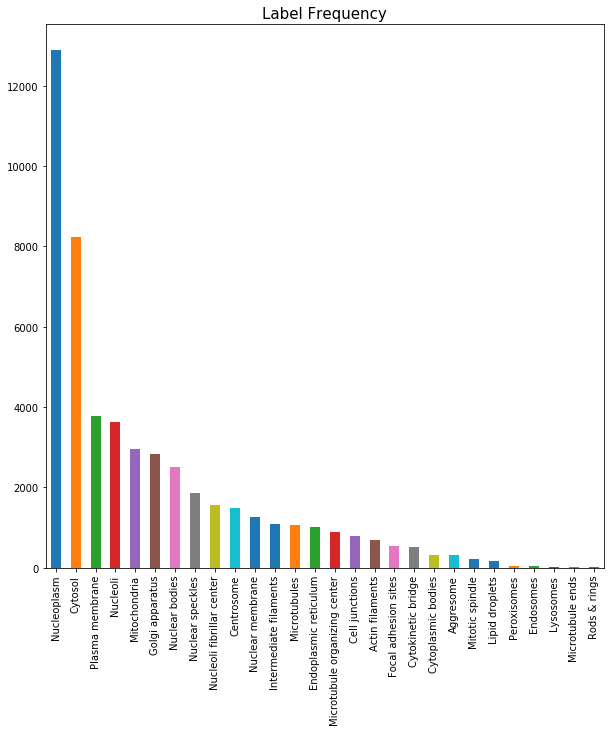

In [9]:
label_counts = train_label_names.drop(["Id"], axis=1).sum(axis=0)
label_counts = label_counts.sort_values(ascending=False)
label_rate = label_counts / label_counts.sum()

print("Frequency of top 5 labels:")
print(label_counts.head())
print()
print("Frequency of bottom 5 labels:")
print(label_counts.tail())

plt.figure(figsize=(10,10))
label_counts.plot.bar()
plt.title("Label Frequency", fontsize=15)
plt.savefig("Imbalanced.png")
plt.show()

How many labels appear in each image?

<Figure size 720x720 with 0 Axes>

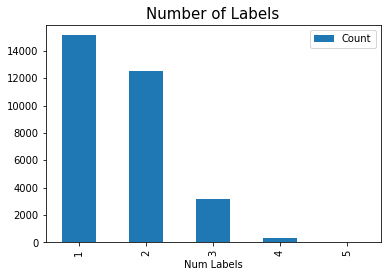

,Count
Num Labels,
1,0.486805
2,0.401809
3,0.101699
4,0.009623
5,0.000064


In [10]:
train_label_counts = train_labels.copy()
train_label_counts['Num Labels'] = 0
def fill_counts(row):
    labels = np.array(row.Target.split()).astype(np.uint8)
    for label in labels:
        row['Num Labels'] += 1
    return row

train_label_counts = train_label_counts.apply(fill_counts, axis=1)
train_label_counts = train_label_counts.groupby(['Num Labels']).count()
train_label_counts = train_label_counts.rename(index=str, columns={"Id": "Count", "Target": "drop"}).drop(['drop'], axis=1)

train_label_count_rate = train_label_counts / train_label_counts.sum()
plt.figure(figsize=(10,10))
train_label_counts.plot.bar()
plt.title("Number of Labels", fontsize=15)
plt.savefig("Counts.png")
plt.show()
train_label_count_rate

Let's create a random labelling function, informed by the above information.

In [11]:
label_pdf = list(zip(label_rate.index, label_rate))
label_pdf = [(int(labels_inverse[x]), y) for (x,y) in label_pdf]
label_xk = [x for x,y in label_pdf]
label_pk = [y for x,y in label_pdf]

label_distribution = stats.rv_discrete(values=(label_xk, label_pk), badvalue=27)

count_pdf = list(zip(train_label_count_rate['Count'].index, train_label_count_rate['Count']))
count_pdf = [(int(x), y) for (x,y) in count_pdf]
count_xk = [x for x,y in count_pdf]
count_pk = [y for x,y in count_pdf]

count_distribution = stats.rv_discrete(values=(count_xk, count_pk), badvalue=5)

class RandomLabeller():
    def __init__(self, label_dist, count_dist, targets, df_true=None):
        self.label_dist = label_dist
        self.count_dist = count_dist
        self.targets = targets
        self.df_true = df_true
        
    def label(self, row):
        count = self.count_dist.rvs()
        labels = [self.label_dist.rvs() for i in range(count)]
        for i in labels: 
            row[label_names[i]] = 1
        return row
    
    def gen_labels(self):
        df_start = {}
        for col in self.df_true.columns[1:]:
            df_start[col] = [0]*len(self.targets)

        result = pd.DataFrame(df_start, index=self.targets, columns=self.df_true.columns[1:])
        result = result.apply(self.label, axis=1)
        
        # save results
        self.labels = result
        return result

random_labeller = RandomLabeller(label_distribution, 
                                 count_distribution, 
                                 train_label_names['Id'], 
                                 df_true = train_label_names)

result = random_labeller.gen_labels()

Also going to need a scoring function to evaluate this.

In [12]:
import keras.backend as K
import tensorflow as tf

thresholds_optimal = [0.68, 0.08, 0.22, 0.16, 0.54, 0.18, 
              0.23, 0.4, 1.0, 0.03, 0.02, 0.08, 0.33, 
              0.37, 0.05, 1.0, 1.0, 0.08, 0.25, 0.25, 1.0, 
              0.38, 0.31, 0.54, 0.08, 0.53, 0.08, 1.0]

def apply_threshold(y_pred, thresholds=thresholds_optimal):
    #y_pred = y_pred.as_matrix()
    for i in range(len(y_pred[0])):
        y_pred_idx_yes = y_pred[:,i] >= thresholds[i]
        y_pred[:,i] = 1 and y_pred_idx_yes
        
    return np.array(y_pred).astype(np.uint8)

def F1(y_true, y_pred):
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
    return f1

# https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

def f1(y_true, y_pred, threshold=0.25):
    #y_pred = apply_threshold(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

With this random model, let's run some experiments.

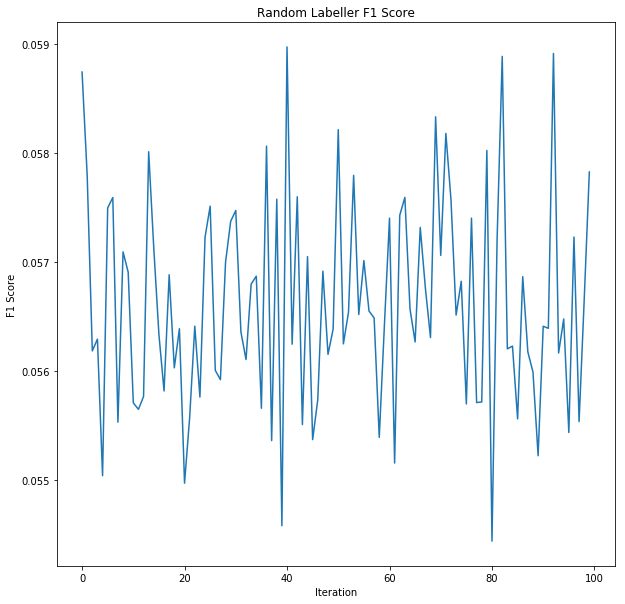

The mean F1 score is 0.0566 with a standard deviation of 0.001


In [52]:
n = 10
iterations = np.linspace(0, n-1, n)

score = []
y_true = train_label_names.set_index("Id")

for i in range(len(iterations)):
    result = random_labeller.gen_labels()
    score += [f1(y_true, result)]
    
plt.figure(figsize=(10,10))

plt.plot(iterations, score)
plt.title("Random Labeller F1 Score")
plt.xlabel("Iteration")
plt.ylabel("F1 Score")
plt.show()

mean = np.mean(score)
std = np.std(score)

print("The mean F1 score is", round(mean, 4), "with a standard deviation of", round(std, 4))

Now, we have a baseline. Time to do some real work.

In [13]:
from imgaug import augmenters as iaa

# Data generator, creds to this tutorial: 
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class ProteinDataGenerator(keras.utils.Sequence):
    def __init__(self, ids, labels, directory='train', 
                 batch_size=32, 
                 dim=(64,64), n_channels=4,
                 n_classes=28, shuffle=True, augmentation=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.directory = directory
        self.labels = labels
        self.ids = ids
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation
    
    def __data_generation(self, ids_temp):
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=np.uint64)

        # Generate data
        for i, ID in enumerate(ids_temp):
            # Store sample
            red = cv2.imread('../input/' + self.directory + '/' + ID + '_red.png',0)
            green = cv2.imread('../input/' + self.directory + '/' + ID + '_green.png',0)
            blue = cv2.imread('../input/' + self.directory + '/' + ID + '_blue.png',0)
            yellow = cv2.imread('../input/' + self.directory + '/' + ID + '_yellow.png',0)
            
            red = cv2.resize(red, self.dim)
            red = np.divide(red, 255)
            green = cv2.resize(green, self.dim)
            green = np.divide(green, 255) 
            blue = cv2.resize(blue, self.dim)
            blue = np.divide(blue, 255) 
            yellow = cv2.resize(yellow, self.dim)
            yellow = np.divide(yellow, 255) 
            
            stacked = np.stack([red, green, blue, yellow], axis=2)
            
            X[i,] = stacked

            # Store class
            y[i] = self.labels.loc[ID]
            
        return X, y
    
    def __len__(self):
        return int(np.floor(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        ids_temp = [self.ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(ids_temp)
        
        if self.augmentation:
            X = self.__augment(X)
            
        return X, y
    
    # https://imgaug.readthedocs.io/en/latest/source/examples_basics.html
    def __augment(self, images):
        seq = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            iaa.Flipud(0.5), # Vertical
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            iaa.Sometimes(0.5, 
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5)
            ),
            iaa.Sometimes(0.25, 
                iaa.Add(50, per_channel=True)
            ),
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-25, 25)
            ),
            iaa.Dropout(p=(0, 0.2))
        ], random_order=True) # apply augmenters in random order

        images_aug = seq.augment_images(images)
        return images
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# Split into training and validation

# TESTING ONLY:
#train_label_names = train_label_names.sample(3000)

n_validation = np.floor(train_label_names.shape[0] * 0.2).astype(np.uint64)
validation_df = train_label_names.sample(n_validation)
training_df = train_label_names.drop(validation_df.index)

validation_df = validation_df.set_index("Id")
training_df = training_df.set_index("Id")

In [14]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, Dense, MaxPooling2D, \
                         Dropout, Flatten, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

In [15]:
# Parameters
input_shape = (256, 256)
input_dim = (input_shape[0], input_shape[1], 4)
batch_size = 64

params = {'dim': input_shape,
          'batch_size': batch_size,
          'n_classes': 28,
          'n_channels': 4,
          'shuffle': True,
          'augmentation': True}

# Generators
training_generator = ProteinDataGenerator(training_df.index, training_df, directory='train', **params)
validation_generator = ProteinDataGenerator(validation_df.index, validation_df, directory='train', **params)

# Add some dropout after each convolutional layer
# https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
# http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf
dropout = 0.1

model = Sequential()

model.add(Conv2D(8, (3, 3), input_shape=input_dim, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))

model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(28))
model.add(Activation('sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc', f1])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 8)       296       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 16)        0         
__________

In [47]:
from keras_tqdm import TQDMNotebookCallback

num_epochs = 100

# https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L460
# https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L360

filepath = '../input/model.hdf5'
callbacks = [
    TQDMNotebookCallback(),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0), 
    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
]
model_history = model.fit_generator(generator=training_generator,
                                    validation_data=validation_generator,
                                    epochs=num_epochs,
                                    verbose=0,
                                    callbacks=callbacks,
                                    use_multiprocessing=False
                                    )

model.save("protein.hdf5")


Epoch 00001: val_loss improved from inf to 0.17117, saving model to ../input/model.hdf5



Epoch 00002: val_loss improved from 0.17117 to 0.15580, saving model to ../input/model.hdf5



Epoch 00003: val_loss improved from 0.15580 to 0.15294, saving model to ../input/model.hdf5



Epoch 00004: val_loss improved from 0.15294 to 0.15219, saving model to ../input/model.hdf5



Epoch 00005: val_loss did not improve from 0.15219



Epoch 00006: val_loss improved from 0.15219 to 0.13387, saving model to ../input/model.hdf5



Epoch 00007: val_loss improved from 0.13387 to 0.13190, saving model to ../input/model.hdf5



Epoch 00008: val_loss improved from 0.13190 to 0.12749, saving model to ../input/model.hdf5



Epoch 00009: val_loss improved from 0.12749 to 0.11957, saving model to ../input/model.hdf5



Epoch 00010: val_loss did not improve from 0.11957



Epoch 00011: val_loss did not improve from 0.11957



Epoch 00012: val_loss improved from 0.11957 to 0.11587, saving model to ../input/model.hdf5



Epoch 00013: val_loss did not improve from 0.11587



Epoch 00014: val_loss did not improve from 0.11587



Epoch 00015: val_loss did not improve from 0.11587



Epoch 00016: val_loss did not improve from 0.11587



Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00017: val_loss did not improve from 0.11587



Epoch 00018: val_loss improved from 0.11587 to 0.10824, saving model to ../input/model.hdf5



Epoch 00019: val_loss did not improve from 0.10824



Epoch 00020: val_loss improved from 0.10824 to 0.10812, saving model to ../input/model.hdf5



Epoch 00021: val_loss did not improve from 0.10812



Epoch 00022: val_loss did not improve from 0.10812



Epoch 00023: val_loss did not improve from 0.10812



Epoch 00024: val_loss did not improve from 0.10812



Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: val_loss did not improve from 0.10812



Epoch 00026: val_loss did not improve from 0.10812



Epoch 00027: val_loss did not improve from 0.10812



Epoch 00028: val_loss did not improve from 0.10812



Epoch 00029: val_loss did not improve from 0.10812



Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00030: val_loss did not improve from 0.10812
Epoch 00030: early stopping


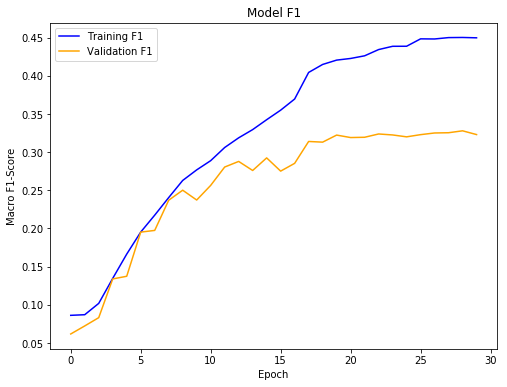

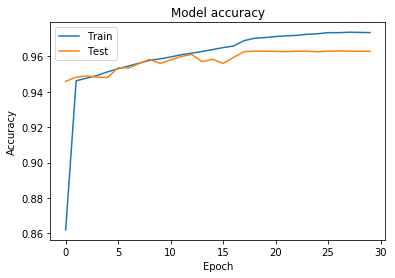

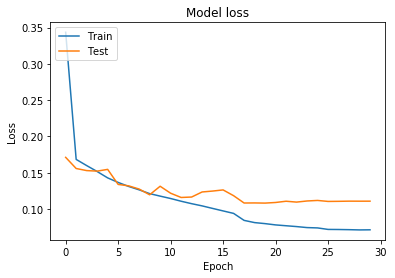

In [50]:
def create_model_plot(model_history):
    
    plt.figure(figsize=(8,6))
    
    plt.title("Model F1")
    plt.plot(model_history.epoch, model_history.history['f1'], color='blue', label='Training F1')
    plt.plot(model_history.epoch, model_history.history['val_f1'], color='orange', label='Validation F1')

    plt.xlabel("Epoch")
    plt.ylabel("Macro F1-Score")
    plt.legend(loc='upper left')
    plt.show()
        
    # https://keras.io/visualization/
    plt.plot(model_history.history['acc']) 
    plt.plot(model_history.history['val_acc'])
    plt.title('Model accuracy') 
    plt.ylabel('Accuracy') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show() 
    
    plt.plot(model_history.history['loss']) 
    plt.plot(model_history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show() 

create_model_plot(model_history)

Cool, we have a decent model! Now, the one flaw here is that the threshold of 0.1 we used for the F1 score was pretty arbitrary - we can do better, which will further improve our model.

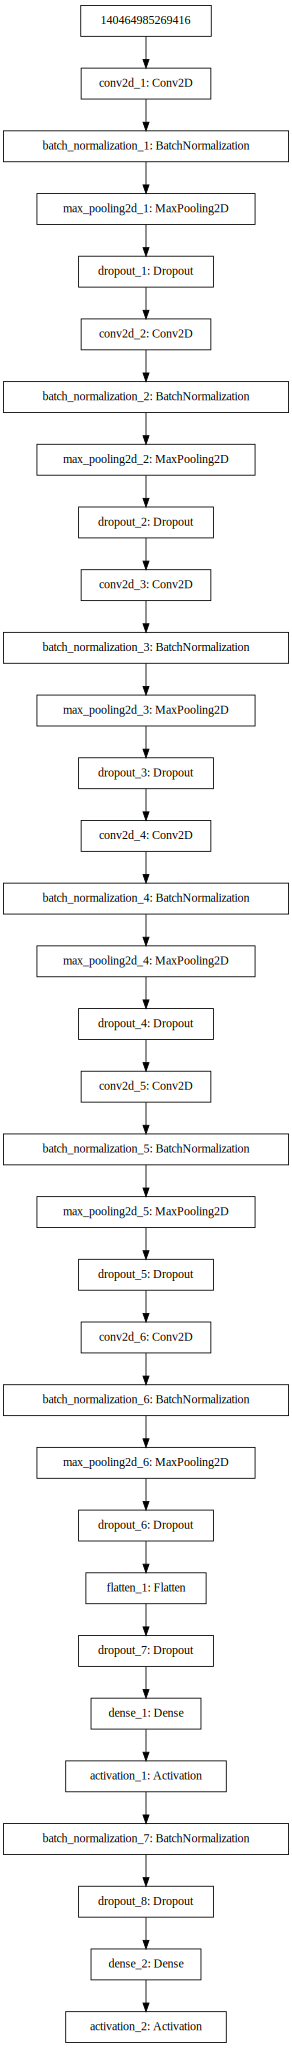

In [16]:
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot 

model.load_weights('../input/model.hdf5')

keras.utils.plot_model(model, to_file='../input/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg')) 

In [53]:
from sklearn.metrics import accuracy_score
def find_optimal_threshold(y_true, y_pred):
    n_classes = len(y_pred[0])
    thresholds = np.linspace(0,1,101)
    scores = [[0]*101]*n_classes
    for i in range(len(y_pred[0])):
        for t in range(len(thresholds)):
            y_pred_single = y_pred[:,i]
            y_pred_single = [1 if y > thresholds[t] else 0 for y in y_pred_single]
            y_true_single = y_true[:,i]
            scores[i][t] = accuracy_score(y_true_single, y_pred_single)
        scores[i] = np.asarray(scores[i])        
        
    maxes = [0]*28
    for i in range(len(maxes)):
        maxes[i] = thresholds[np.argmax(scores[i])]
    
    return maxes

validation_generator_full = ProteinDataGenerator(validation_df.index, validation_df, 
                                                 directory='train', dim=input_shape, 
                                                 batch_size=validation_df.shape[0], n_classes=28,
                                                 n_channels=4, shuffle=False, augmentation=False)

ids = []
labels = []
x, y_true = validation_generator_full[0]
y_pred = model.predict(x)
thresholds = find_optimal_threshold(y_true, y_pred)
print(thresholds)

[0.59, 0.23, 0.45, 0.25, 0.2, 0.54, 0.58, 0.61, 0.09, 0.06, 0.02, 0.34, 0.6, 0.39, 0.55, 0.03, 0.81, 0.38, 0.38, 0.5700000000000001, 0.12, 0.48, 0.53, 0.34, 0.21, 0.58, 0.38, 0.01]


Finally, using these as our thresholds, let's reevaluate the model and see what our new F1 score is.

In [18]:
thresholds = [0.59, 0.23, 0.45, 0.25, 0.2, 0.54, 
               0.58, 0.61, 0.09, 0.06, 0.02, 0.34, 
               0.6, 0.39, 0.55, 0.03, 0.81, 0.38, 
               0.38, 0.57, 0.12, 0.48, 0.53, 0.34, 
               0.21, 0.58, 0.38, 0.01]

validation_generator_full = ProteinDataGenerator(validation_df.index, validation_df, 
                                                 directory='train', dim=input_shape, 
                                                 batch_size=validation_df.shape[0], n_classes=28,
                                                 n_channels=4, shuffle=False, augmentation=False)

x, y_true = validation_generator_full[0]
y_pred = model.predict(x)
y_pred = apply_threshold(y_pred, thresholds=thresholds)
f1_with_thresholds = F1(y_true, y_pred)
print('F1 score with new thresholds is:', f1_with_thresholds)

F1 score with new thresholds is: 0.606376874618718


That's a solid improvement! Now let's label the test data.

In [17]:
thresholds = [0.59, 0.23, 0.45, 0.25, 0.2, 0.54, 
               0.58, 0.61, 0.09, 0.06, 0.02, 0.34, 
               0.6, 0.39, 0.55, 0.03, 0.81, 0.38, 
               0.38, 0.57, 0.12, 0.48, 0.53, 0.34, 
               0.21, 0.58, 0.38, 0.01]

test_df = pd.read_csv("../input/sample_submission.csv", engine='python')
test_df = test_df.drop(['Predicted'], axis=1)
test_df = test_df.set_index("Id")
for k,v in label_names.items():
    test_df[v] = 0

test_generator = ProteinDataGenerator(test_df.index, test_df, 
                                      directory='test', dim=input_shape, 
                                      batch_size=5851, n_classes=28,
                                      n_channels=4, shuffle=False, augmentation=False)

ids = []
labels = []
for t in range(len(test_generator)):
    x, y = test_generator[t]
    y_pred = model.predict(x)
    class_labels = apply_threshold(y_pred, thresholds)
    for i in range(len(x)):
        pred = ""
        for j in range(len(class_labels[i])):
            if class_labels[i][j] == 1:
                pred += " " + str(j)
        
            if len(pred) > 0 and pred[0] == " ":
                pred = pred[1:]
            
        ids += [test_df.index[i]]
        labels += [pred]
    print("Just finished iter " + str(t+1) + "/" + str(len(test_generator)))

test_labelled = pd.DataFrame(pd.Series(ids), columns=['Id'])
test_labelled['Predicted'] = labels
test_labelled.to_csv('../input/submission.csv', index=False)
test_labelled

Just finished iter 1/2
Just finished iter 2/2


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,25
